In [1]:
import os
from collections import Counter
from itertools import cycle

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


import lightning.pytorch as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torch.optim.lr_scheduler
import wandb
from imblearn.over_sampling import SMOTE
from lightning.pytorch.callbacks import Callback, LearningRateMonitor
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import WandbLogger
from pandas import DataFrame
from sklearn.calibration import label_binarize
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from torch import nn, utils
from torch.utils.data import DataLoader, Dataset

print(torch.__version__)
print(pl.__version__)
device_string = (
    "mps"
    if torch.backends.mps.is_built()
    else "cuda:0"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"MPS Available : {torch.backends.mps.is_built()}")
print(f"CUDA availabe : {torch.cuda.is_available()}")
DEVICE = torch.device(device_string)
print(f"GPU - {DEVICE}")


2.0.1
2.0.2
MPS Available : True
CUDA availabe : False
GPU - mps


In [2]:
import os

os.getpid()


42865

# Data Preparation

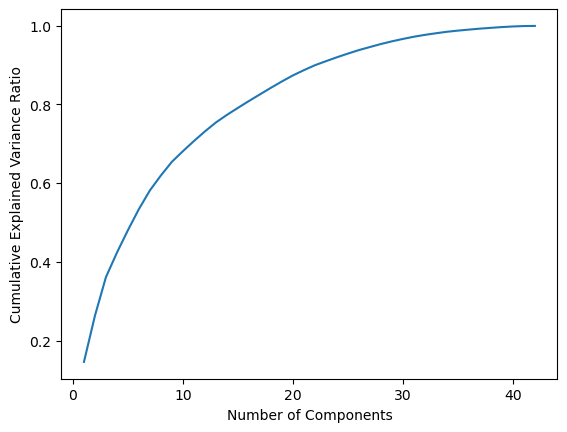

#>============================================================<#
	Dropping class: 34	 As there is only 4 instance
#>============================================================<#
At class 31: 32 examples 	which is Miscellaneous 
#>============================================================<#
	Dropping class: 30	 As there is only 2 instance
#>============================================================<#
At class 29: 28 examples 	which is Alcoholic beverages 
At class 28: 33 examples 	which is Confectionery and cereal/nut/fruit/seed bars 
#>============================================================<#
	Dropping class: 27	 As there is only 19 instance
#>============================================================<#
#>============================================================<#
	Dropping class: 26	 As there is only 11 instance
#>============================================================<#
At class 24: 235 examples 	which is Vegetable products and dishes 
At class 23: 37 examples 	wh

In [3]:
df: DataFrame = pd.read_excel(
    io="./Datasets/Rel_2_Nutrient_file.xlsx", sheet_name="All solids & liquids per 100g"
)
df["Classification"] = df["Classification"].astype(str)
df["Classification"] = pd.to_numeric(
    df["Classification"].str.extract(r"(\d{2})")[0], errors="coerce"
)

new_df: DataFrame = (
    df.filter(regex="^(?!.*\(%T\)).*")
    .drop(
        labels=[
            "Public Food Key",
            "Food Name",
        ],
        axis=1,
    )
    .dropna(thresh=(int(len(df) * 0.99)), axis=1)
    .dropna()
)

classifications_df: DataFrame = pd.read_excel(
    io="./Datasets/Australian_Health_Survey_Classification_System.xlsx"
)
classifications_df = classifications_df[
    (classifications_df["Food Group Code"] // 100).between(0, 1)
]

classifications = pd.Series(
    classifications_df["Food Group and Sub-Group Name"],
    index=classifications_df["Food Group Code"].values,
).to_dict()

classifications = dict(
    zip(
        classifications_df["Food Group Code"],
        classifications_df["Food Group and Sub-Group Name"],
    )
)
class_list = new_df.Classification.tolist()

use_pca: bool = True

if use_pca:
    features = new_df.drop(
        "Classification", axis=1
    )  # Drop the target column to get the features
    target = new_df["Classification"]  # Save the target column separately
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    pca = PCA(n_components=42)  # Choose the desired number of components
    pca_result = pca.fit_transform(scaled_features)

    pca_df = pd.DataFrame(
        data=pca_result,
        columns=[
            "PC1",
            "PC2",
            "PC3",
            "PC4",
            "PC5",
            "PC6",
            "PC7",
            "PC8",
            "PC9",
            "PC10",
            "PC11",
            "PC12",
            "PC13",
            "PC14",
            "PC15",
            "PC16",
            "PC17",
            "PC18",
            "PC19",
            "PC20",
            "PC21",
            "PC22",
            "PC23",
            "PC24",
            "PC25",
            "PC26",
            "PC27",
            "PC28",
            "PC29",
            "PC30",
            "PC31",
            "PC32",
            "PC33",
            "PC34",
            "PC35",
            "PC36",
            "PC37",
            "PC38",
            "PC39",
            "PC40",
            "PC41",
            "PC42",
        ],
    )  # Adjust column names as needed

    final_df = pd.concat([pca_df, target], axis=1)

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    import matplotlib.pyplot as plt

    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance Ratio")
    plt.show()

    new_df = final_df.copy()

class_counts = Counter(new_df["Classification"].copy())
for element, count in class_counts.items():
    if count <= 20:
        new_df = new_df.drop(new_df[new_df["Classification"] == element].index)
        print("#>============================================================<#")
        print(f"\tDropping class: {element}\t As there is only {count} instance")
        print("#>============================================================<#")
    else:
        print(
            f"At class {element}: {count} examples \twhich is {classifications.get(element)}"
        )

print(class_counts)

n_classes: int = len(pd.unique(new_df.Classification))

print(f"Num classes: {n_classes}")
print(Counter(new_df["Classification"].copy()))

print(new_df.head())


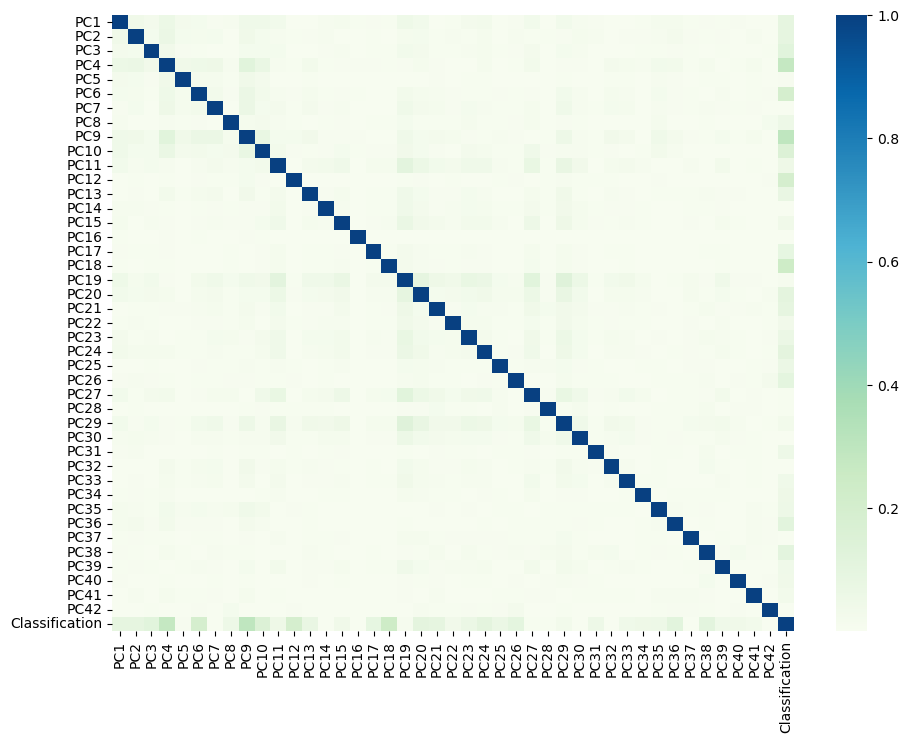

In [4]:
corr = new_df.corr(min_periods=0).abs()
plt.figure(figsize=(11, 8))
sns.heatmap(corr, cmap="GnBu", annot=False)
plt.show()


new_df.Classification = new_df.Classification.map(classifications)


In [5]:
# print(new_df.Classification)
train, test = train_test_split(
    new_df,
    test_size=0.3,
    random_state=42,
    shuffle=True,
    stratify=new_df.Classification,
)
smote = SMOTE(random_state=42, k_neighbors=3)
X_train = train.drop(columns=["Classification"])
y_train = train["Classification"]
X_train, y_train = smote.fit_resample(X_train, y_train)
X_test = test.drop(columns=["Classification"])
y_test = test["Classification"]


# Split the original dataset into features and labels
X = new_df.drop(columns=["Classification"])
y = new_df["Classification"]

# Apply SMOTE to the entire dataset
smote = SMOTE(random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X, y)

# # Split the resampled dataset into train and test sets
MLP_X_train, MLP_X_test, MLP_y_train, MLP_y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.4,
    random_state=42,
    shuffle=True,
    stratify=y_resampled,
)

# Print the shapes of the train and test sets
print("Train set shapes:", MLP_X_train.shape, MLP_y_train.shape)
print("Test set shapes:", MLP_X_test.shape, MLP_y_test.shape)


Train set shapes: (4464, 42) (4464,)
Test set shapes: (2976, 42) (2976,)


In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

MLP_scaler = StandardScaler()
MLP_X_train = scaler.fit_transform(MLP_X_train)
MLP_X_test = scaler.transform(MLP_X_test)


# KNN classifier

In [7]:
# Create the k-NN classifier with k=3
k = 3
knn = KNeighborsClassifier(n_neighbors=k)

# Fit the classifier to the training data
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=3)

In [8]:
# Make predictions on the training set and calculate the training loss
y_train_pred = knn.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_loss = 1 - train_acc

# Make predictions on the test set and calculate the test loss
y_test_pred = knn.predict(X_test)
y_test_pred_proba = knn.predict_proba(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_loss = 1 - test_acc

print(f"Training loss:\t{train_loss:.4f}\tTraining accuracy:\t{train_acc:.4f}")
print(f"Test loss:\t{test_loss:.4f}\tTest accuracy:\t\t{test_acc:.4f}")

knn_report = classification_report(y_test, y_test_pred)
knn_df_report = pd.DataFrame(
    classification_report(y_test, y_test_pred, output_dict=True)
)

print(knn_df_report)


Training loss:	0.0065	Training accuracy:	0.9935
Test loss:	0.1429	Test accuracy:		0.8571
           Alcoholic beverages   Cereal based products and dishes   
precision                   1.0                          0.641026  \
recall                      1.0                          0.806452   
f1-score                    1.0                          0.714286   
support                     8.0                         31.000000   

           Cereals and cereal products    
precision                      0.840909  \
recall                         0.755102   
f1-score                       0.795699   
support                       49.000000   

           Confectionery and cereal/nut/fruit/seed bars    
precision                                       0.833333  \
recall                                          0.500000   
f1-score                                        0.625000   
support                                        10.000000   

           Dairy & meat substitutes  Fats and oi

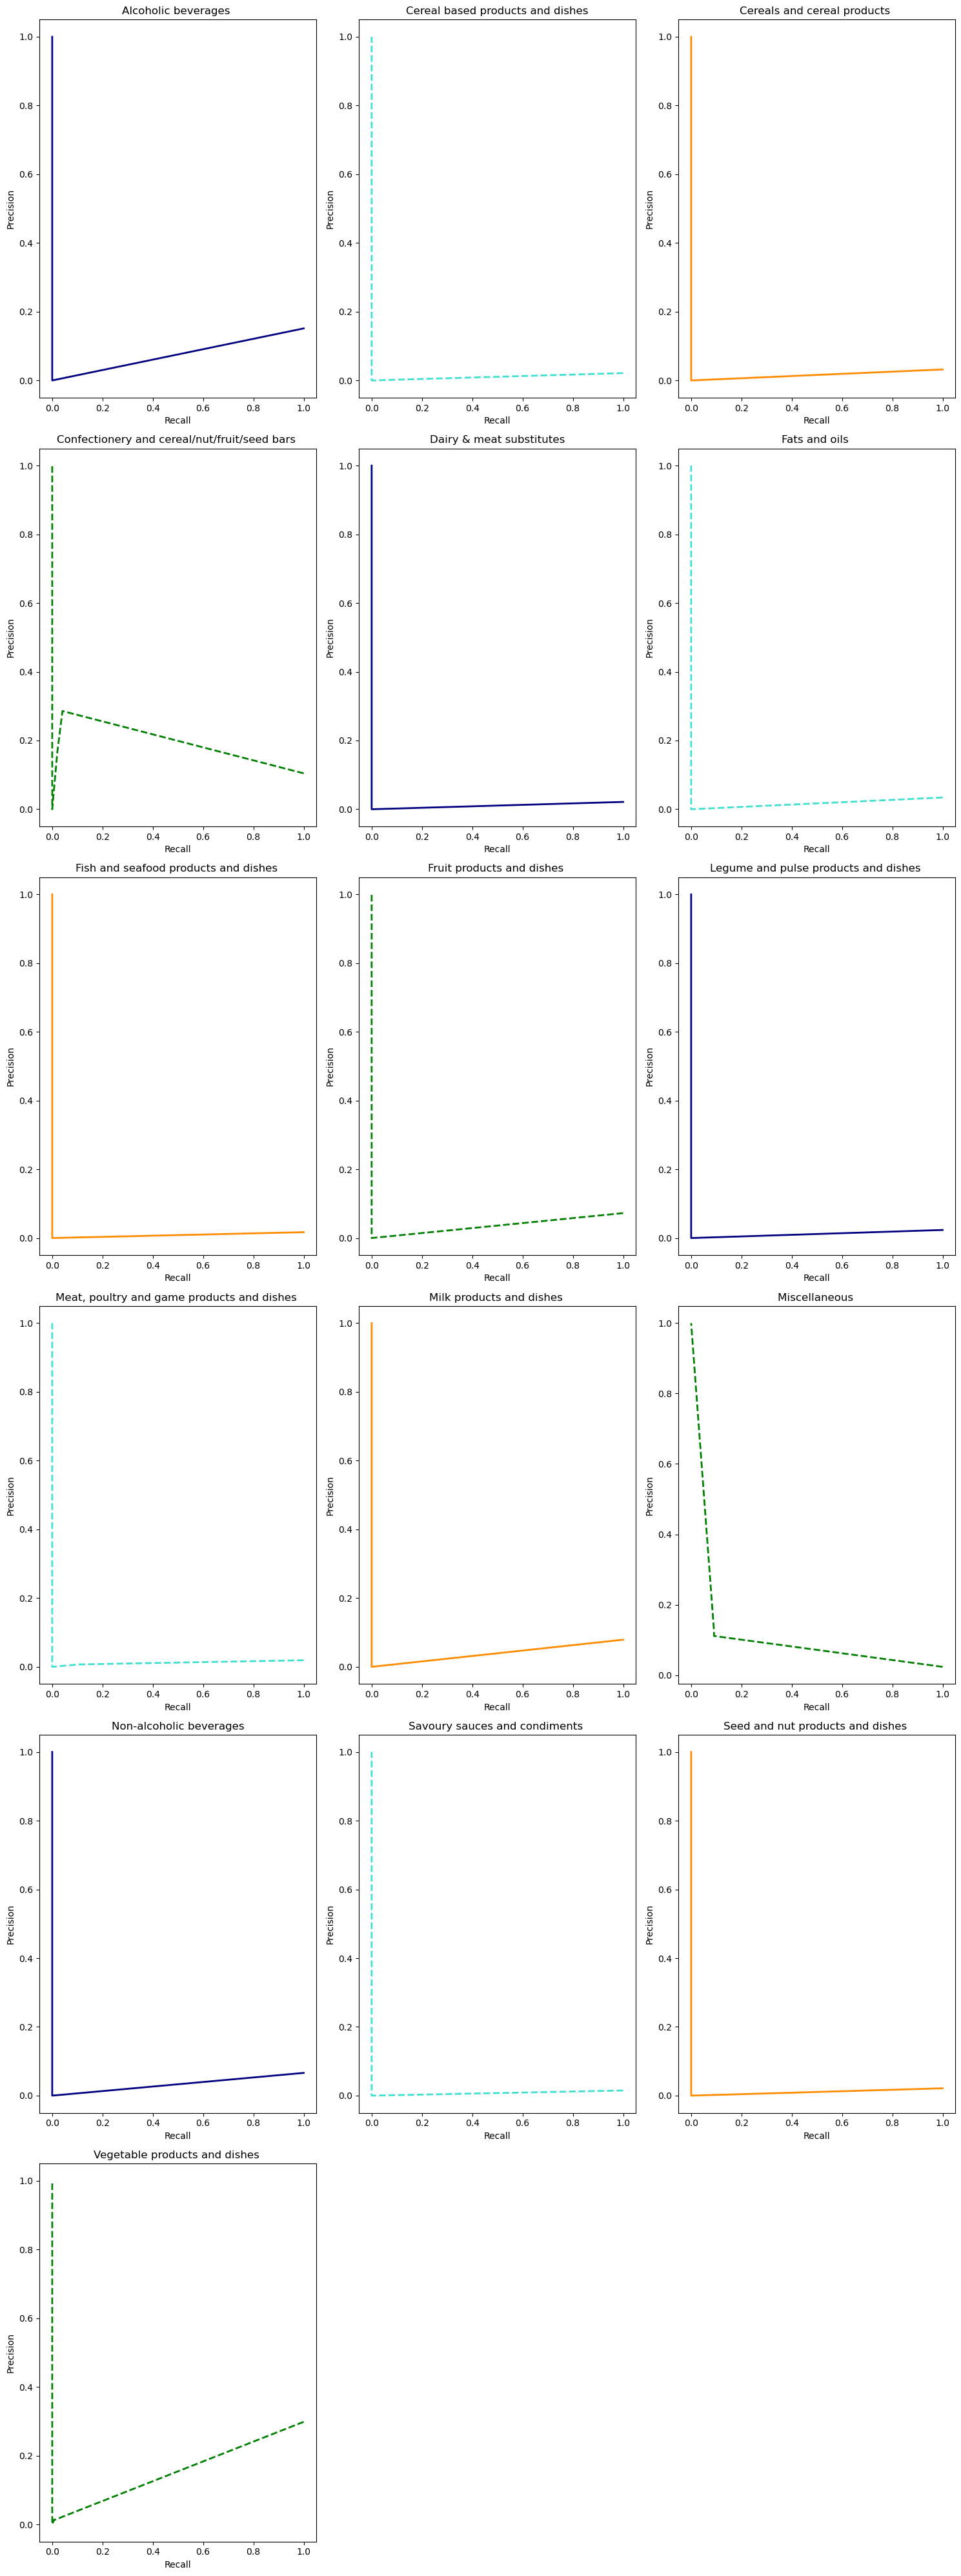

In [9]:
# Binarize the true labels
binarized_labels = label_binarize(y_test, classes=list(set(y_test)))

# Calculate precision and recall for each class
precision = dict()
recall = dict()
n_classes = len(set(y_test))
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(
        binarized_labels[:, i], [proba[i] for proba in y_test_pred_proba]
    )

# Define the number of subplots and the subplot layout
n_subplots = 3
n_rows = (n_classes + n_subplots - 1) // n_subplots
n_cols = min(n_subplots, n_classes)

# Create subplots for precision-recall curves
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 40))
axs = axs.flatten()

# Plot the precision-recall curves for each class
colors = cycle(["navy", "turquoise", "darkorange", "green"])
line_styles = cycle(["-", "--"])
for i, ax in zip(range(n_classes), axs):
    color = next(colors)
    linestyle = next(line_styles)
    ax.plot(recall[i], precision[i], color=color, linestyle=linestyle, lw=2)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"{knn.classes_[i]}")

# Remove empty subplots if needed
if n_classes < len(axs):
    for j in range(n_classes, len(axs)):
        fig.delaxes(axs[j])

# Adjust the spacing between subplots
fig.tight_layout()

plt.show()


# Random Forest Classifier

Best accuracy of 0.8763 found with a depth of 8
           Alcoholic beverages   Cereal based products and dishes   
precision                   1.0                          0.833333  \
recall                      1.0                          0.806452   
f1-score                    1.0                          0.819672   
support                     8.0                         31.000000   

           Cereals and cereal products    
precision                      0.857143  \
recall                         0.857143   
f1-score                       0.857143   
support                       49.000000   

           Confectionery and cereal/nut/fruit/seed bars    
precision                                       0.625000  \
recall                                          0.500000   
f1-score                                        0.555556   
support                                        10.000000   

           Dairy & meat substitutes  Fats and oils    
precision                  0.53333

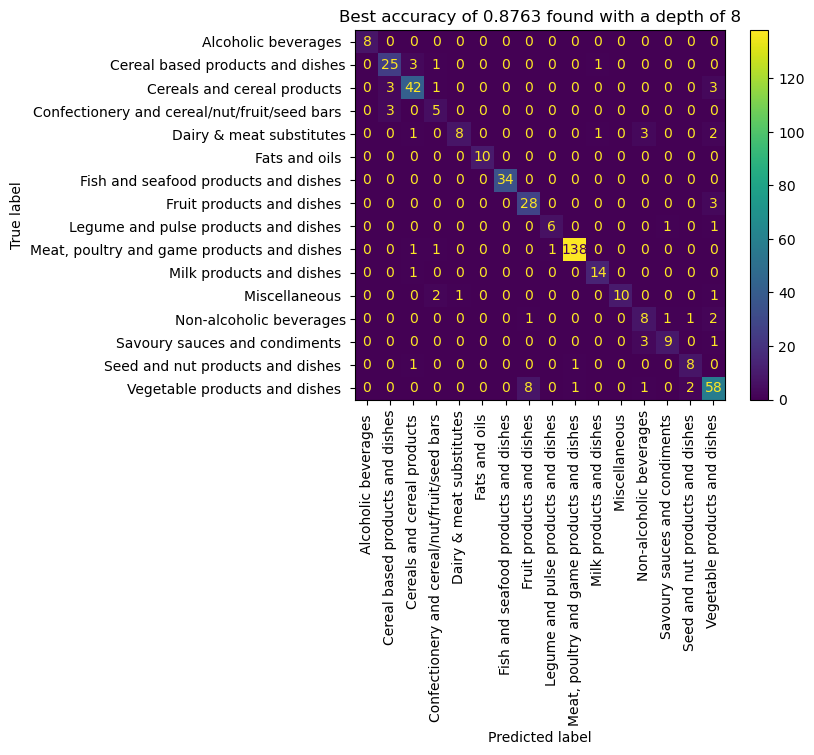

In [10]:
depths: list[int] = [2, 4, 8]
best_acc: int = -1
best_depth: int = -1
best_cm = None
best_model = None

for depth in depths:
    clf = RandomForestClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_loss = 1 - train_acc

    # Make predictions on the test set and calculate the test loss
    y_test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_loss = 1 - test_acc

    if test_acc > best_acc:
        best_acc = test_acc
        best_depth = depth
        best_model = clf
        best_predict = y_test_pred
        best_predict_proba = clf.predict_proba(X_test)
        # Plot the decision regions and training/test data points
        best_cm = confusion_matrix(y_test_pred, y_test, labels=clf.classes_)

fig, ax = plt.subplots()
ax.set_title(f"Best accuracy of {best_acc:.4f} found with a depth of {best_depth}")

disp: ConfusionMatrixDisplay = ConfusionMatrixDisplay(
    confusion_matrix=best_cm,
    display_labels=clf.classes_,
).plot(xticks_rotation="vertical", ax=ax)

report = classification_report(y_test, y_test_pred)
df_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))

print(f"Best accuracy of {best_acc:.4f} found with a depth of {best_depth}")
print(df_report)


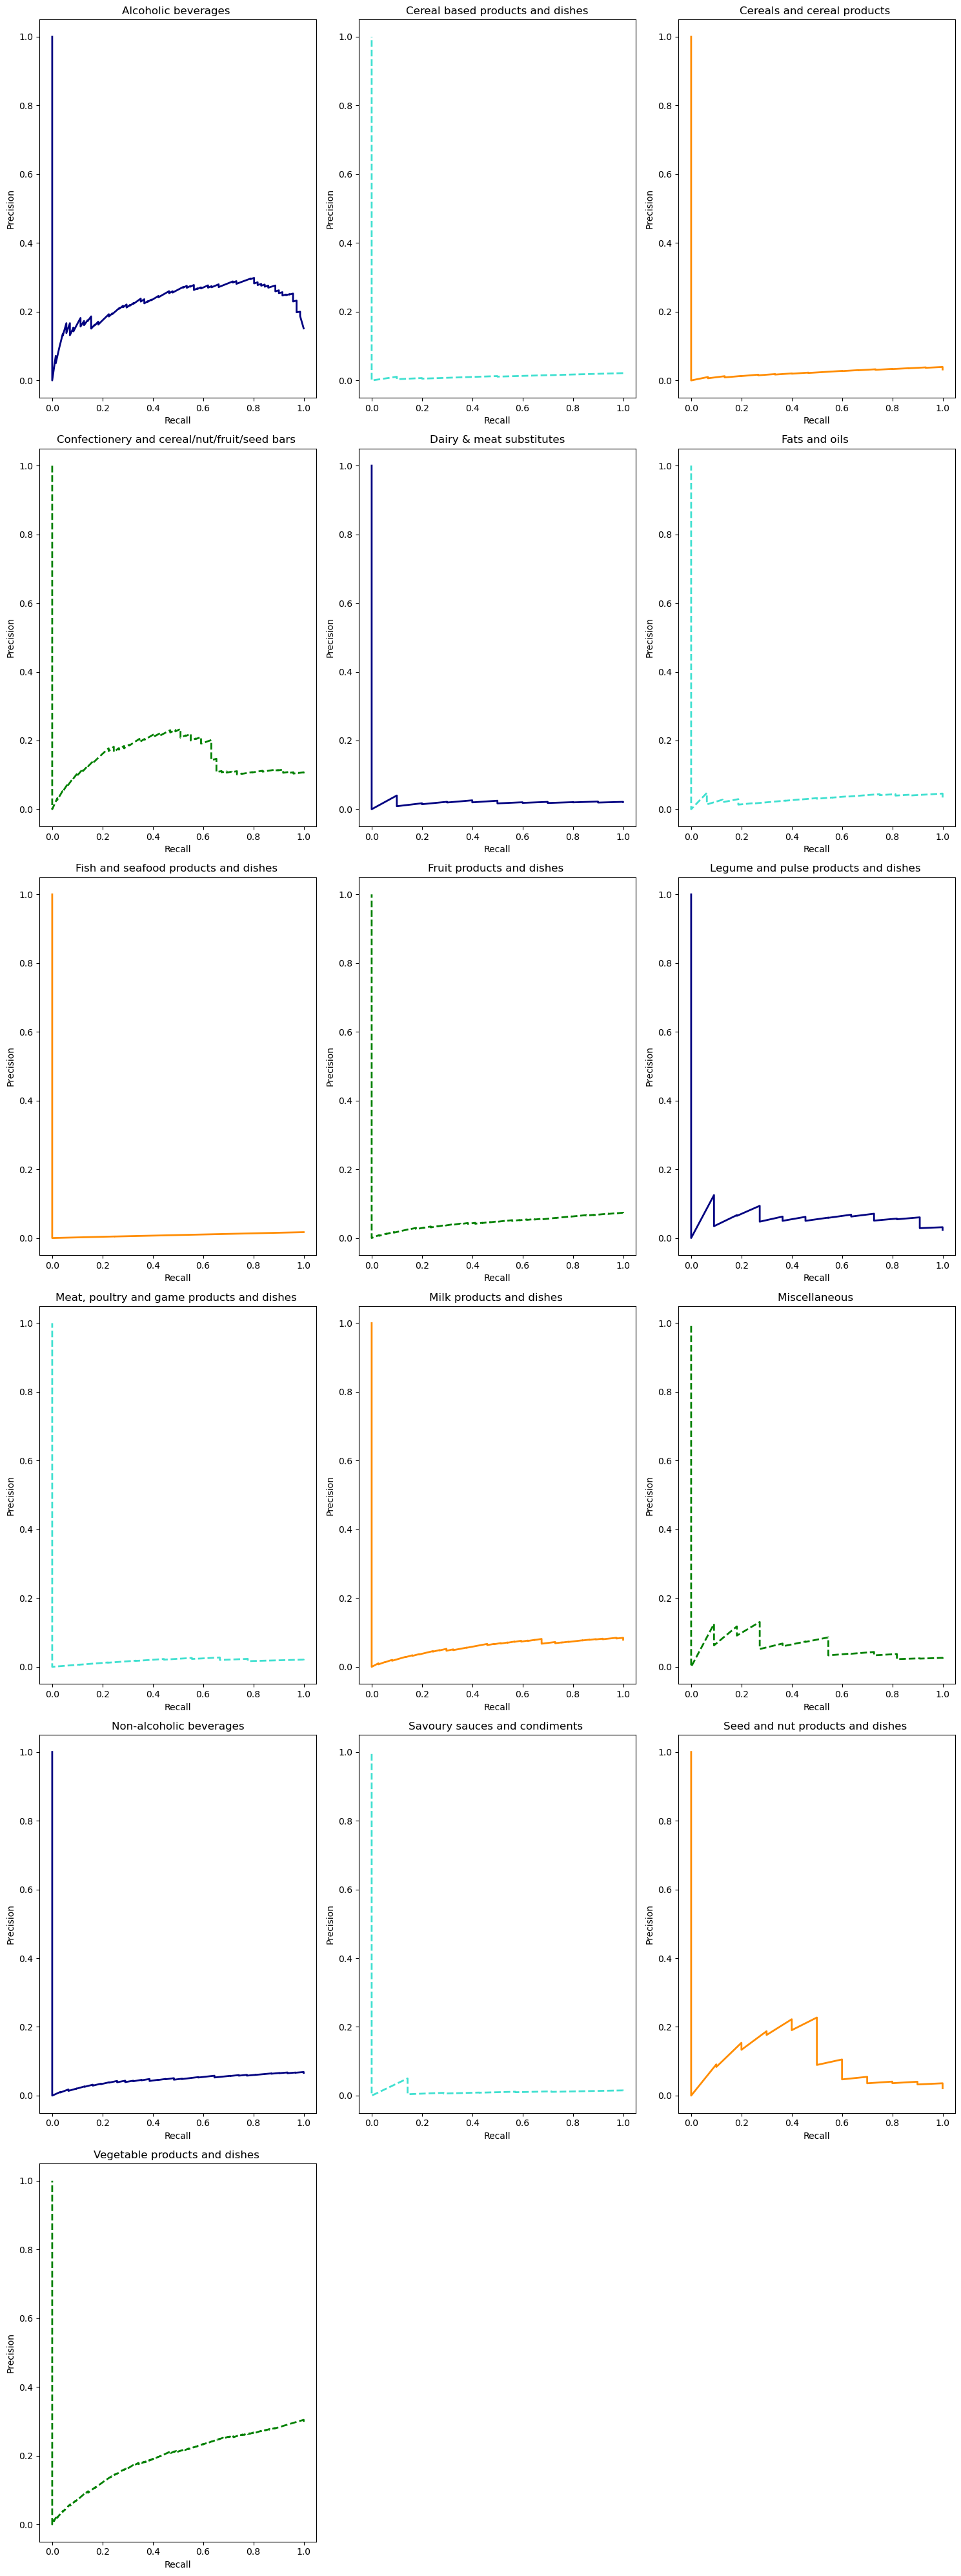

In [11]:
# Binarize the true labels
binarized_labels = label_binarize(y_test, classes=list(set(y_test)))

# Calculate precision and recall for each class
precision = dict()
recall = dict()
n_classes = len(set(y_test))
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(
        binarized_labels[:, i], [proba[i] for proba in best_predict_proba]
    )

# Define the number of subplots and the subplot layout
n_subplots = 3
n_rows = (n_classes + n_subplots - 1) // n_subplots
n_cols = min(n_subplots, n_classes)

# Create subplots for precision-recall curves
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 40))
axs = axs.flatten()

# Plot the precision-recall curves for each class
colors = cycle(["navy", "turquoise", "darkorange", "green"])
line_styles = cycle(["-", "--"])
for i, ax in zip(range(n_classes), axs):
    color = next(colors)
    linestyle = next(line_styles)
    ax.plot(recall[i], precision[i], color=color, linestyle=linestyle, lw=2)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"{best_model.classes_[i]}")

# Remove empty subplots if needed
if n_classes < len(axs):
    for j in range(n_classes, len(axs)):
        fig.delaxes(axs[j])

# Adjust the spacing between subplots
fig.tight_layout()

plt.show()


# CNN

In [12]:
class myTrainDataSet(Dataset):
    def __init__(self, x_train_df: DataFrame, y_train_df):
        self.X_train = torch.tensor(x_train_df, dtype=torch.float32)
        self.y_train = torch.tensor(y_train_df.values, dtype=torch.int)

    def __len__(self) -> int:
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]


class myTestDataSet(Dataset):
    def __init__(self, x_test_df: DataFrame, y_test_df: DataFrame):
        self.X_test = torch.tensor(x_test_df, dtype=torch.float32)
        self.y_test = torch.tensor(y_test_df.values, dtype=torch.int)

    def __len__(self) -> int:
        return len(self.y_test)

    def __getitem__(self, idx):
        return self.X_test[idx], self.y_test[idx]


In [13]:
class CNNClassifier(pl.LightningModule):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_classes,
        lr,
        dropout_rate=0.5,
    ):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels=1,
            out_channels=hidden_size,
            kernel_size=3,
            stride=2,
        )
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)

        # self.conv2 = nn.Conv1d(
        #     in_channels=hidden_size,
        #     out_channels=hidden_size * 2,
        #     kernel_size=3,
        #     stride=2,
        # )
        # self.pool2 = nn.MaxPool1d(kernel_size=2)
        # self.batchnorm2 = nn.BatchNorm1d(hidden_size * 2)
        # self.dropout2 = nn.Dropout(dropout_rate)

        self.fc1 = nn.Linear(hidden_size * 2, num_classes)

        # Initialize weights
        nn.init.xavier_uniform_(self.fc1.weight)

        self.learning_rate = lr

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension for 1D convolution
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        x = self.dropout1(x)
        # x = F.relu(self.conv2(x))
        # x = self.pool2(x)
        # x = self.batchnorm2(x)
        # x = self.dropout2(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch

        # Forward pass
        y_hat = self(x)

        # Calculate loss
        loss = F.cross_entropy(y_hat, y)

        # Log accuracy and loss (optional)
        self.log("train_loss", loss, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        _, predicted = torch.max(y_hat, dim=1)

        # Calculate accuracy
        accuracy = torch.sum(predicted == y).item() / len(y)
        self.log("val_acc", accuracy, prog_bar=True, on_epoch=True)
        self.log(
            "val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log(
            "test_loss",
            loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        _, predicted_labels = torch.max(y_hat, 1)
        accuracy = torch.sum(predicted_labels == y).item() / len(y)
        self.log(
            "test_accuracy",
            accuracy,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.learning_rate, weight_decay=0.0001
        )

        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer=optimizer, step_size=40, gamma=0.1
        )
        scheduler_dict = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "val_loss",
        }

        return [optimizer], [scheduler_dict]


In [14]:
reversed_dict = {value: key for key, value in classifications.items()}
train_dataset = myTrainDataSet(MLP_X_train, MLP_y_train.map(reversed_dict))
test_dataset = myTrainDataSet(MLP_X_test, MLP_y_test.map(reversed_dict))

testitem = torch.cat((train_dataset.y_train.unsqueeze(1), train_dataset.X_train), dim=1)

# use 20% of training data for validation
train_set_size = int(len(train_dataset) * 0.8)
valid_set_size = len(train_dataset) - train_set_size

# split the train set into two
seed = torch.Generator().manual_seed(42)
train_dataset, val_dataset = utils.data.random_split(
    train_dataset,
    [train_set_size, valid_set_size],
    generator=seed,
)


In [15]:
print(train_dataset)


In [16]:
# Data setup
batch_size = 1
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
)

input_size = MLP_X_train.shape[1]
hidden_size = 16
num_classes = len(new_df["Classification"].unique())
lr = 1e-3
EPOCHS = 200

model = CNNClassifier(
    input_size=input_size,
    hidden_size=hidden_size,
    num_classes=num_classes,
    lr=lr,
)

wandb.finish(1)
wandb.init(
    project="Nutrition_Assignment_",
    config={
        "learning_rate": lr,
        "batch_size": batch_size,
        "hidden_size": hidden_size,
        "input_size": input_size,
        "num_classes": num_classes,
        "model_architecture": "CNN",
        "dataset": "Nutrition",
    },
)

wandb_logger = WandbLogger(project="Nutrition_Assignment_")
# Create the EarlyStopping and LearningRateMonitor callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=20)
lr_monitor = LearningRateMonitor(logging_interval="step")
callback_list: list[Callback] = [early_stopping, lr_monitor]

# Trainer setup
trainer = pl.Trainer(max_epochs=EPOCHS, logger=wandb_logger, callbacks=callback_list)

# Model training
trainer.fit(model, train_loader, val_loader)

# Model testing
trainer.test(model, test_loader)

# Additional evaluation on test set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

print(classification_report(y_true, y_pred))


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alexvillr. Use `wandb login --relogin` to force relogin


/Users/alexviller/micromamba/envs/testenv/lib/python3.11/site-packages/lightning/pytorch/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type        | Params
-------------------------------------------
0 | conv1      | Conv1d      | 64    
1 | pool1      | MaxPool1d   | 0     
2 | batchnorm1 | BatchNorm1d | 32    
3 | dropout1   | Dropout     | 0     
4 | fc1        | Linear      | 528   
-------------------------------------------
624       Trainable params
0         Non-trainable params
624       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/alexviller/micromamba/envs/testenv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


: 

: 

In [ ]:
new_train_dataset = myTestDataSet(MLP_X_train, MLP_y_train.map(reversed_dict))
new_train_dataloader = DataLoader(dataset=new_train_dataset, batch_size=batch_size)

new_test_dataset = myTestDataSet(MLP_X_test, MLP_y_test.map(reversed_dict))
new_test_loader = DataLoader(dataset=new_test_dataset, batch_size=batch_size)


In [ ]:
# Binarize the multiclass labels
y_test_binary = label_binarize(new_test_dataset.y_test, classes=range(num_classes))
print(num_classes)

print(y_test_binary.shape)
print(new_test_dataset.X_test.shape)

# Get predicted probabilities from your PyTorch MLP model
model.eval()
with torch.no_grad():
    model_output = model(new_test_dataset.X_test)
    print(model_output.shape)
    class_probabilities = torch.softmax(model_output, dim=1).cpu().numpy()

# Calculate precision-recall curve for each class
precision = dict()
recall = dict()
thresholds = dict()

for class_index in range(num_classes):
    # Obtain the true labels for the current class
    class_labels = y_test_binary[:, class_index]
    class_probabilities_class = class_probabilities[:, class_index]

    # Calculate precision, recall, and thresholds for the current class
    (
        precision[class_index],
        recall[class_index],
        thresholds[class_index],
    ) = precision_recall_curve(class_labels, class_probabilities_class)

# Iterate over the test dataset and obtain predictions
predicted_labels = []
true_labels = []

for inputs, labels in new_test_loader:
    # Forward pass
    outputs = model(inputs)
    _, predicted = torch.max(outputs, dim=1)

    # Append predicted and true labels
    predicted_labels.extend(predicted.tolist())
    true_labels.extend(labels.tolist())


In [ ]:
# Filter the class labels dictionary based on existing classes
filtered_dict = {
    label: value for label, value in classifications.items() if label in true_labels
}

# Update the class labels dictionary with the filtered dictionary
class_labels_dict = filtered_dict

print(len(filtered_dict))

# Convert lists to tensors
predicted_labels = torch.tensor(predicted_labels)
true_labels = torch.tensor(true_labels)

# Calculate confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Convert true and predicted labels to indices using the reverse mapping
true_labels_indices = [classifications.get(label.item()) for label in true_labels]
predicted_labels_indices = [
    classifications.get(label.item()) for label in predicted_labels
]

# Calculate confusion matrix
confusion_mat = confusion_matrix(
    true_labels_indices,
    predicted_labels_indices,
    labels=list(class_labels_dict.values()),
)

# Create ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=confusion_mat, display_labels=list(class_labels_dict.values())
).plot(xticks_rotation="vertical")

# Set axis labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Show the plot
plt.show()
print(confusion_mat)


In [ ]:
classes = MLP_y_test.map(reversed_dict)
new_counter = Counter(classes)
print(new_counter)
# Define the number of subplots and the subplot layout
n_subplots = 3
n_rows = (n_classes + n_subplots - 1) // n_subplots
n_cols = min(n_subplots, n_classes)

# Create subplots for precision-recall curves
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 40))
axs = axs.flatten()

# Plot the precision-recall curves for each class
colors = cycle(["navy", "turquoise", "darkorange", "green"])
line_styles = cycle(["-", "--"])
for i, ax in zip(range(n_classes), axs):
    color = next(colors)
    linestyle = next(line_styles)
    ax.plot(recall[i], precision[i], color=color, linestyle=linestyle, lw=2)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"{classifications.get(list(new_counter.keys())[i])}")

# Remove empty subplots if needed
if n_classes < len(axs):
    for j in range(n_classes, len(axs)):
        fig.delaxes(axs[j])

# Adjust the spacing between subplots
fig.tight_layout()

plt.show()
